# Stock Price Forecasting using LSTM

Source https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [1]:
import math
import yfinance as yf 
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
plt.style.use('Solarize_Light2')

## Get the Data
Use yfinance to aquire the data

In [2]:
stock_name = 'AAPL'
stock_start_date = '2016-01-01'
stock_end_date = '2021-10-01'
stock_data = yf.download(stock_name, start=stock_start_date, end=stock_end_date)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.199886,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.220575,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.613628,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.151516,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.174414,324377600


Visualize the data as a graph

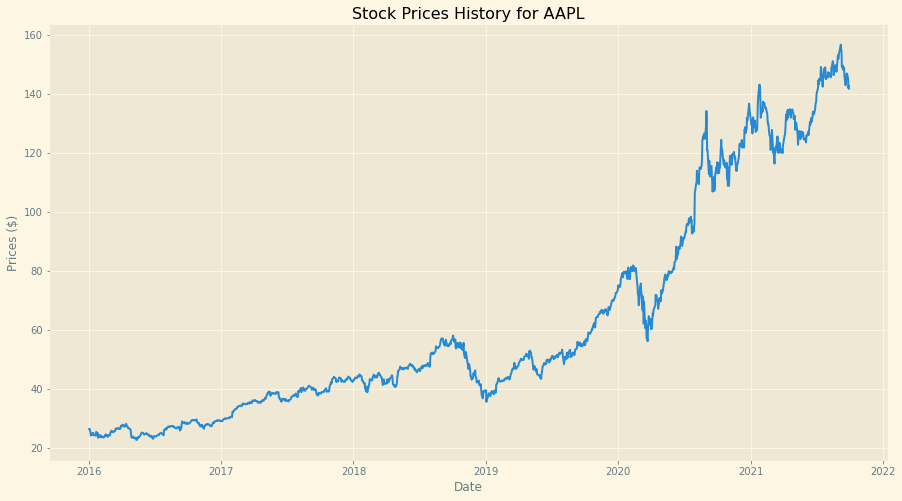

In [3]:
plt.figure(figsize=(15,8))
plt.title('Stock Prices History for ' + stock_name)
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.show()

## Preprocess the Data

### Training Set
1. Create a 80-20 split 
2. Normalize the data into values between 0 and 1
3. Reshape the data into values between -1 and 1

note: wouldnt tanh be better here ? 

In [4]:
close_price = stock_data['Close']
values = close_price.values
training_data_len = math.ceil(len(values) * 0.8)

scalar = MinMaxScaler(feature_range=(0, 1)) # Normalize the data, side note could apply sigmoid instead maybe ?? 
scaled_data = scalar.fit_transform(values.reshape(-1, 1))
training_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

4. Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label date (y_train)
5. Convert data into numpy arrays

In [5]:
for i in range(60, len(training_data)):
    x_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])


# Convert the data to numpy arrays for tensorflow reasons 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Test set

In [6]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = values[training_data_len]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Model
Create a LSTM model

In [7]:
# model = keras.Sequential()
# model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(layers.LSTM(100, return_sequences=False))
# model.add(layers.Dense(25))
# model.add(layers.Dense(1))
# model.summary()

### Testing different models
Lower RMSE score is better (Mostly using 5 epochs)

Roni special (2 hidden layers, 2 dense layers) ~ 3 epochs: 19.314, 13.907, 21.1 ---- 10 epochs: 15.936, 20.902, 15.945

Vanilla LSTM ~ 15.029, 18.717, 19,363, 22.388, 21.663

StockPricePrediction_v4a: ~ 1 epoch: 1.718, 12.448, 6.457, 13.923  --2 epochs: 2.202, 23.365, 19.8855  --3 epochs: 4.481, 4.489, 5.509 --5 epochs: 15.003, 20.026, 3.727, 3.726, 10.533, 22.181, 9.489, 9.537  --10 epochs:  37.428

In [8]:
# Testing different models
# Vanilla LSTM
# model = keras.Sequential()
# model.add(layers.LSTM(50, activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(layers.Dense(1))

# StockPricePredicition setup
model = keras.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(layers.Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(layers.LSTM(50))
model.add(layers.Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(layers.Dense(1))

## Training
Train the model

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
1099/1099 [==============================] - 56s 47ms/step - loss: 0.0032
Epoch 2/5
1099/1099 [==============================] - 53s 48ms/step - loss: 0.0016
Epoch 3/5
1099/1099 [==============================] - 44s 40ms/step - loss: 0.0014
Epoch 4/5
1099/1099 [==============================] - 44s 40ms/step - loss: 0.0011
Epoch 5/5
1099/1099 [==============================] - 49s 45ms/step - loss: 0.0014


Evaluate the model with rmse

In [10]:
predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

4.563262462615967


## Visualize the result, i.e the forcast

C:\Users\Jamie\AppData\Local\Temp\ipykernel_8276\22098056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


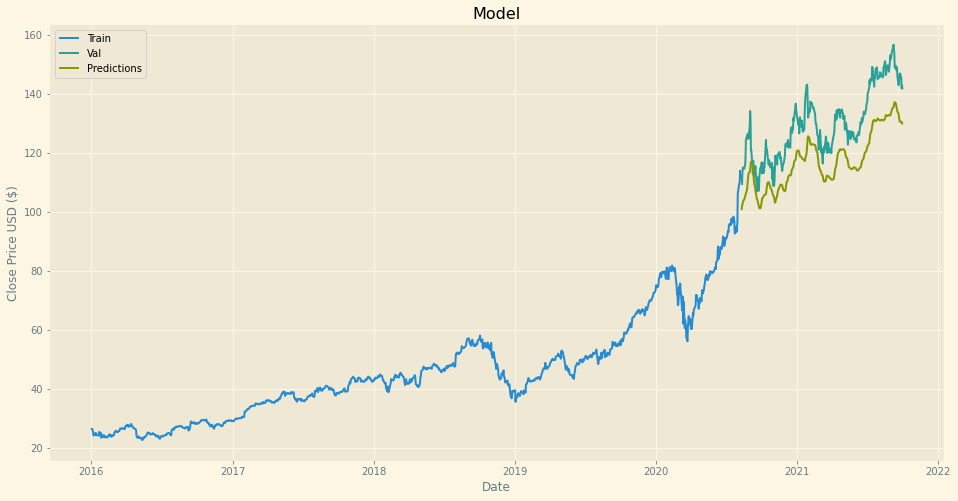

In [11]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
#plt.xlim([18400,18900])
plt.show()

In [22]:
from überLSTM import Attention as lstma
import pandas as pd 
import psycopg2 as pg 
import numpy as np
import pickle
import random
import pandas as pd
from überLSTM import LSTM
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils.DatasetAccess as db_access
import utils.preprocess as preprocess
import utils.arguments as arg
import warnings
import pickle
import matplotlib.pyplot as plt

from main import get_data

In [3]:
model_path = "LSTM_Models/R2_0.9839161833819612_MSE_0.01466678468452098_MAE_0.08215299416138735_model_LayerN_1_BatchSize_32_Epoch_50_NHidden_128_NClass_2_LR_0.001_WinodwSize_100_OutputSize_10.p"
model = open(model_path, "rb")
model = pickle.load(model)
print(model)

Attention(
  (enc_cell): RNN(2, 128, dropout=0.5)
  (dec_cell): RNN(2, 128, dropout=0.5)
  (attn): Linear(in_features=128, out_features=128, bias=True)
  (pls): Linear(in_features=2304, out_features=1, bias=True)
)


In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
connection = pg.connect("dbname=stonksdb user=postgres password=stonk")
mode = 2
primary_category = db_access.get_primay_category(connection) if mode == 0 else None
secondary_category = db_access.get_secondary_category(connection) if mode == 1 else None
company_id = db_access.get_companyid(connection) if mode == 2 else None

arguments = dotdict()
arguments.primarycategory = primary_category#[:1]
arguments.secondarycategory = secondary_category
arguments.companyid = ['15521', '6043']#list(map(lambda x: str(x), company_id)) if mode == 2 else None
arguments.timeunit = '1T'

from_date = "2021-10-01 00:00:00"
to_date = "2021-12-31 23:59:59"
data = get_data(arguments, connection, from_date, to_date)

Models will be trained on companies with company id in ['15521', '6043']

-----------------------
--- presenting data ---
-----------------------

2 compaines were found. Including:
  - Danske Bank A/S - shape: (26530, 6)
  - A.P. Møller - Mærsk A A/S - shape: (19728, 6)




In [8]:
window_size = 100
Output_size = 10
print("Retriving data from database...")
companies = [db_access.SingleCompany([x],window_size,Output_size) for x in data]
print("Data retrieved")
print("Generating training data...")
train_set = db_access.GenerateDataset(companies)
    

Retriving data from database...
Data retrieved
Generating training data...


In [12]:
train_set[1].shape

(46060, 10, 2)

In [20]:
n_class =2 
test, target_test = train_set
trainer_test = torch.from_numpy(test).float()
targeter_test = torch.from_numpy(target_test).float()
dataset_test = torch.utils.data.TensorDataset(trainer_test,targeter_test)
dtloader_test = torch.utils.data.DataLoader(dataset_test,batch_size=1, shuffle=True, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hidden = torch.zeros(1, 1, 128).to(device)

In [130]:
for x,y in dtloader_test:
    x = x.to(device)
    y = y.to(device)
    if(n_class != 1):
        x = x.squeeze(-1)
        y = y.squeeze(-1)
    else:
        x = x.unsqueeze(-1)
        y = y.unsqueeze(-1)
    output, _ = model(x, hidden, x)
    break     

output = output.reshape(-1).detach().cpu().tolist()
x = x[0,:,-1].reshape(-1).detach().cpu().tolist()
y = y[0,:,-1].reshape(-1).detach().cpu().tolist()

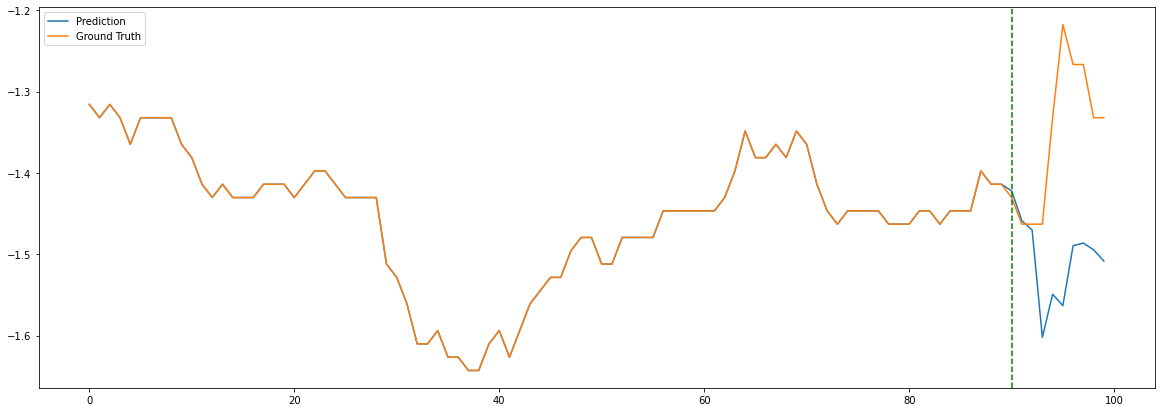

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
ax.plot(x+output, label='Prediction')
ax.plot(x+y, label='Ground Truth')
# plt add v line at 50
ax.axvline(90, color='green', linestyle='--')
ax.legend()
plt.show()


In [42]:
x.shape

torch.Size([1, 90, 2])

In [133]:
np.mean([1,2,3])

2.0